<a href="https://colab.research.google.com/github/yogeshchauhan20/Automatidata/blob/main/Accredian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [24]:
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing>0])

,0
newbalanceDest,0.000001
newbalanceOrig,0.000001
nameDest,0.000001
isFraud,0.000001
isFlaggedFraud,0.000001
oldbalanceDest,0.000001


In [25]:
missing

,0
newbalanceDest,0.000001
newbalanceOrig,0.000001
nameDest,0.000001
isFraud,0.000001
isFlaggedFraud,0.000001
oldbalanceDest,0.000001
step,0.000000
amount,0.000000
type,0.000000
nameOrig,0.000000


In [26]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [27]:
df = df.dropna()

In [28]:
import numpy as np
df['amount_log1p'] = np.log1p(df['amount'].astype('float64'))

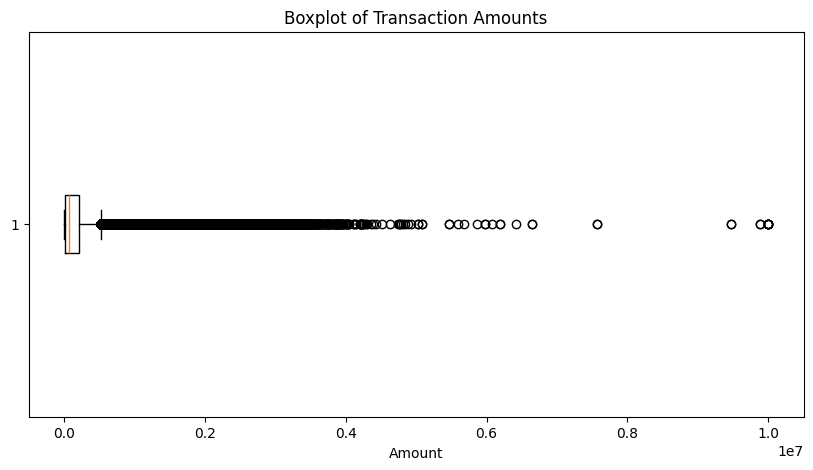

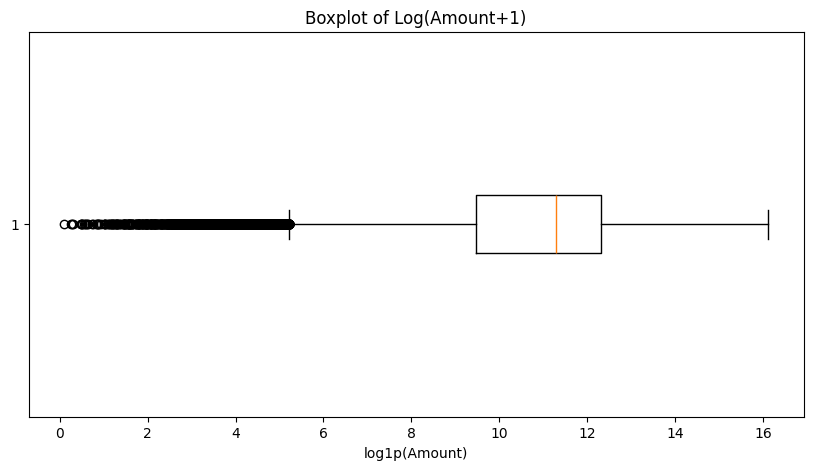

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.boxplot(df['amount'], vert=False, showfliers=True)
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("Amount")
plt.show()
plt.figure(figsize=(10,5))
plt.boxplot(df['amount_log1p'], vert=False, showfliers=True)
plt.title("Boxplot of Log(Amount+1)")
plt.xlabel("log1p(Amount)")
plt.show()

In [30]:
display(df['amount_log1p'])

,amount_log1p
0,9.194276
1,7.531166
2,5.204007
3,5.204007
4,9.364703
...,...
764040,10.004025
764041,8.807943
764042,8.600232
764043,11.228952


In [31]:

df['amount_original'] = df['amount']
upper_limit = df['amount'].quantile(0.999)

print(f"Clipping all transaction amounts above {upper_limit:,.2f}")
df['amount_clipped'] = np.where(df['amount'] > upper_limit, upper_limit, df['amount'])
df['amount_clipped_log1p'] = np.log1p(df['amount_clipped'])


Clipping all transaction amounts above 2,696,236.13


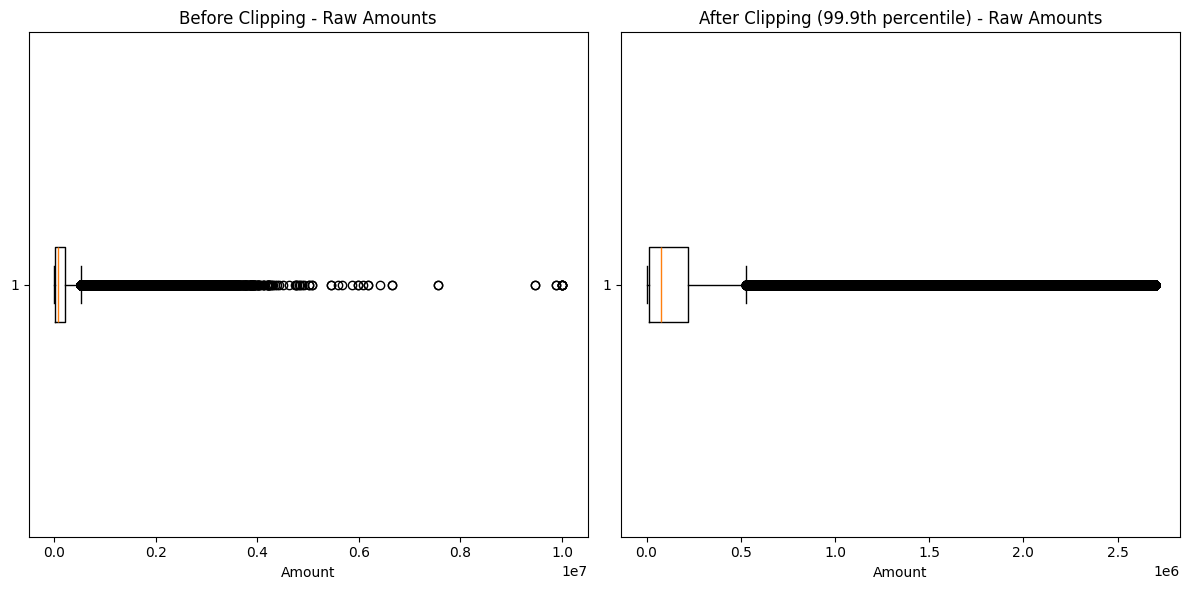

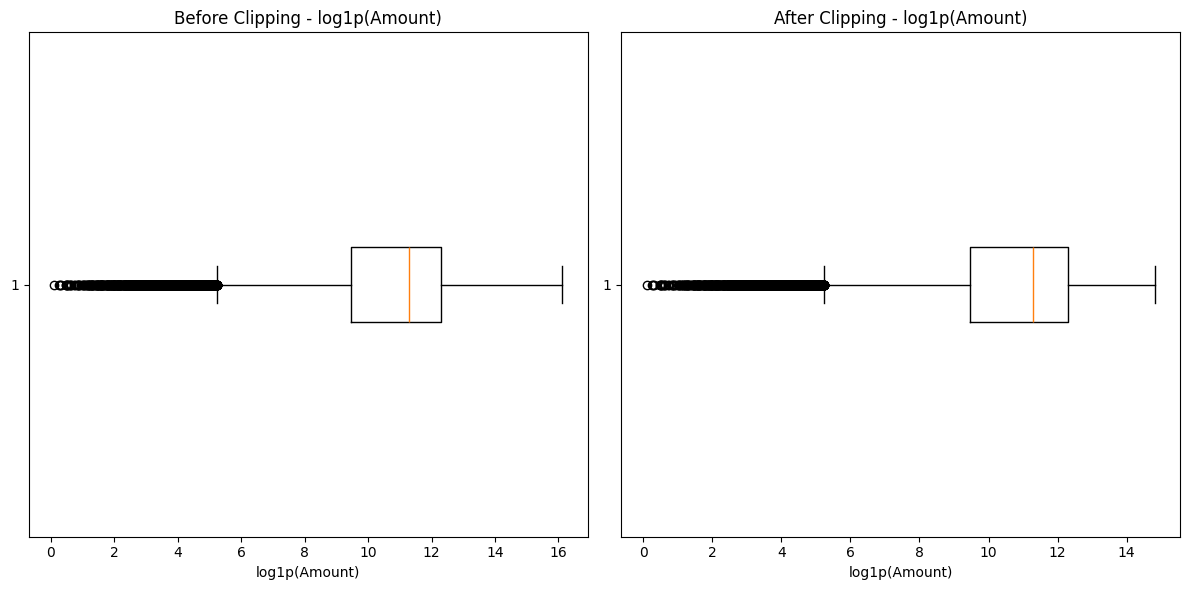

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.boxplot(df['amount'], vert=False, showfliers=True)
plt.title("Before Clipping - Raw Amounts")
plt.xlabel("Amount")
plt.subplot(1,2,2)
plt.boxplot(df['amount_clipped'], vert=False, showfliers=True)
plt.title("After Clipping (99.9th percentile) - Raw Amounts")
plt.xlabel("Amount")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.boxplot(df['amount_log1p'], vert=False, showfliers=True)
plt.title("Before Clipping - log1p(Amount)")
plt.xlabel("log1p(Amount)")
plt.subplot(1,2,2)
plt.boxplot(df['amount_clipped_log1p'], vert=False, showfliers=True)
plt.title("After Clipping - log1p(Amount)")
plt.xlabel("log1p(Amount)")
plt.tight_layout()
plt.show()

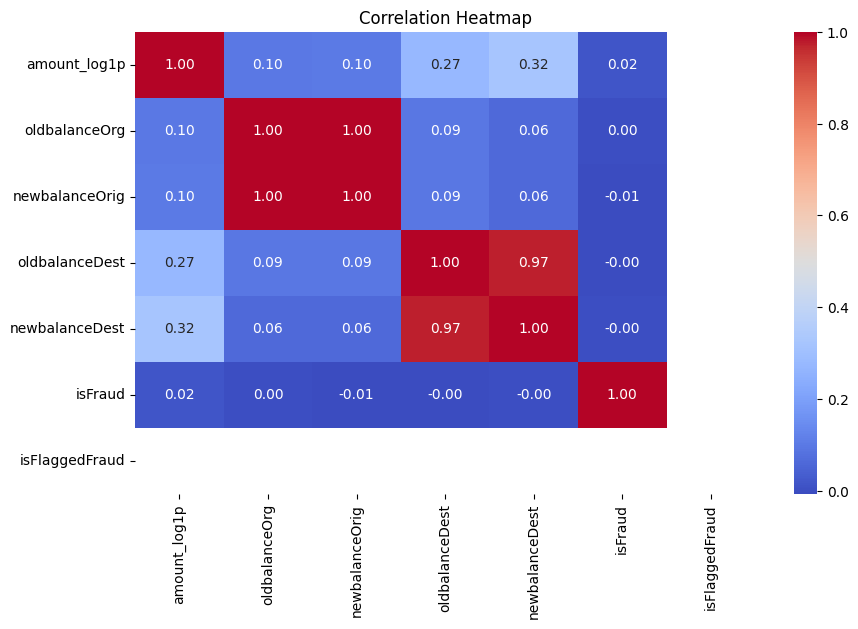

          Feature         VIF
0       Intercept   41.263356
1    amount_log1p    1.220206
2   oldbalanceOrg  676.392686
3  newbalanceOrig  679.361668
4  oldbalanceDest   22.835726
5  newbalanceDest   23.568850


In [33]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.figure(figsize=(10,6))
sns.heatmap(df[['amount_log1p','oldbalanceOrg','newbalanceOrig',
                'oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']]
            .corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
features_for_vif = df[['amount_log1p','oldbalanceOrg','newbalanceOrig',
                       'oldbalanceDest','newbalanceDest']]
X = pd.concat([pd.Series(1, index=features_for_vif.index, name="Intercept"), features_for_vif], axis=1)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


In [34]:
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
df = df.drop(['newbalanceOrig', 'newbalanceDest'], axis=1)
print("Final columns after feature engineering:\n", df.columns.tolist())

Final columns after feature engineering:
 ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud', 'amount_log1p', 'amount_original', 'amount_clipped', 'amount_clipped_log1p', 'deltaOrig', 'deltaDest']


Logistic Regression
              precision    recall  f1-score   support

         0.0     0.9999    0.9119    0.9539    152720
         1.0     0.0053    0.8090    0.0106        89

    accuracy                         0.9118    152809
   macro avg     0.5026    0.8604    0.4822    152809
weighted avg     0.9993    0.9118    0.9533    152809

ROC-AUC: 0.9236302685093083

Random Forest
              precision    recall  f1-score   support

         0.0     0.9996    1.0000    0.9998    152720
         1.0     0.9459    0.3933    0.5556        89

    accuracy                         0.9996    152809
   macro avg     0.9728    0.6966    0.7777    152809
weighted avg     0.9996    0.9996    0.9996    152809

ROC-AUC: 0.9601996530332372

Confusion Matrix - Logistic Regression:
 [[139262  13458]
 [    17     72]]

Confusion Matrix - Random Forest:
 [[152718      2]
 [    54     35]]


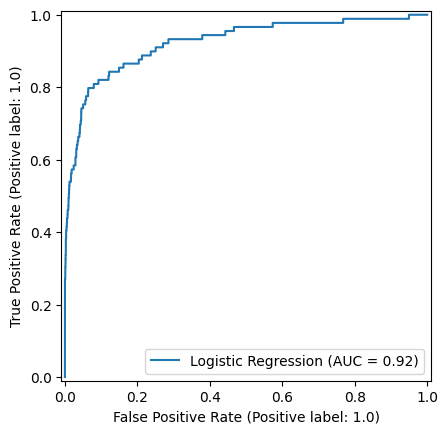

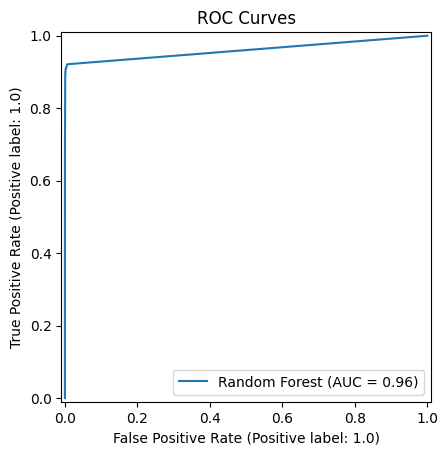

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = df.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'amount_original'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nConfusion Matrix - Logistic Regression:\n", confusion_matrix(y_test, y_pred_lr))
print("\nConfusion Matrix - Random Forest:\n", confusion_matrix(y_test, y_pred_rf))
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest")
plt.title("ROC Curves")
plt.show()

In [38]:
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
import shap
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
prec, rec, thresh = precision_recall_curve(y_test, y_prob_xgb)

f1_scores = 2 * prec * rec / (prec + rec)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"Best Threshold: {best_thresh:.4f}, Precision: {prec[best_idx]:.4f}, Recall: {rec[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")
y_pred_xgb = (y_prob_xgb >= best_thresh).astype(int)

print("\n XGBoost")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:17:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Threshold: 0.9539, Precision: 0.8551, Recall: 0.6629, F1: 0.7468

 XGBoost
              precision    recall  f1-score   support

         0.0     0.9998    0.9999    0.9999    152720
         1.0     0.8551    0.6629    0.7468        89

    accuracy                         0.9997    152809
   macro avg     0.9274    0.8314    0.8734    152809
weighted avg     0.9997    0.9997    0.9997    152809

ROC-AUC: 0.9838683262605871
Confusion Matrix:
 [[152710     10]
 [    30     59]]


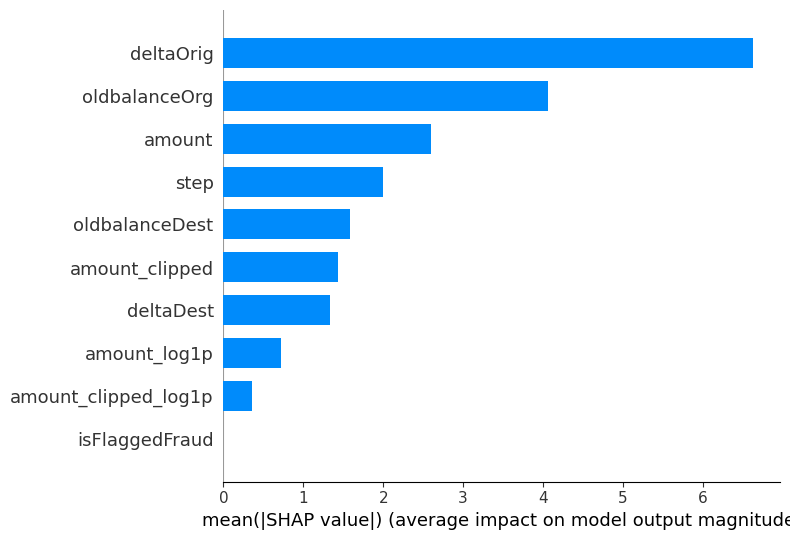

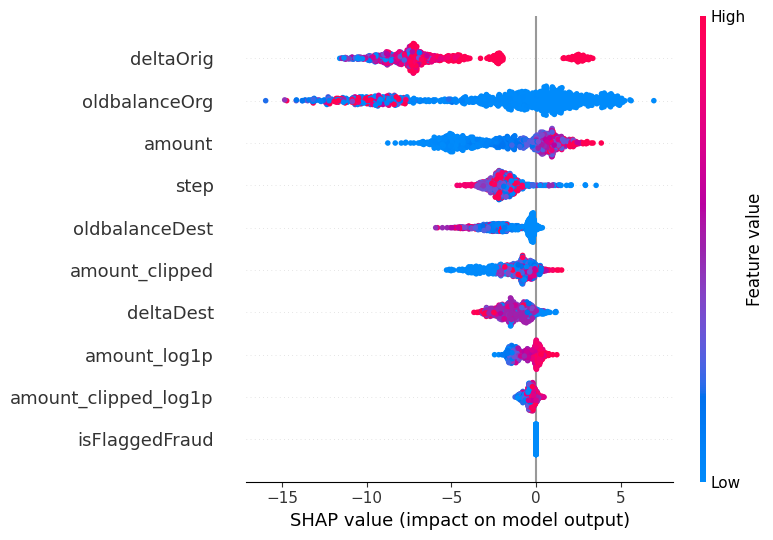

In [39]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test[:1000])
shap.summary_plot(shap_values, X_test[:1000], plot_type="bar")
shap.summary_plot(shap_values, X_test[:1000])